In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
df = pd.read_csv('../speech_emotion_reco/data/merged_dataset.csv')

In [3]:
df.emotion.value_counts()

happy       1924
sad         1923
fear        1923
disgust     1923
angry       1923
neutral     1895
surprise     452
unknown      200
Name: emotion, dtype: int64

In [4]:
df.shape

(12163, 5)

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
unknown_indices = list(df[df['emotion'] == 'unknown'].index)

In [7]:
def load_data(reduction_factor=0.10):
    """transform images to X an y arrays"""
    data_path = '../speech_emotion_reco/data/images/'
    classes = {'happy': 0, 
               'sad': 1,
               'fear': 2,
               'disgust': 3,
               'angry': 4,
               'neutral': 5,
               'surprise': 6,
               'unknown': 7}
    imgs = []
    labels = []
    images_paths = [os.path.join(data_path, path) for path in os.listdir(data_path) if (path.find('.png')>0 and path.replace('.png','') not in unknown_indices)]
    index = 0 
    for path in random.sample(images_paths, int(len(images_paths)*reduction_factor)):
        image = Image.open(path).convert('RGB')
        imgs.append(np.array(image))
        labels.append(classes[df.loc[index, 'emotion']])
        index += 1
        
    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    p = np.random.permutation(len(X))
    print(p)
    X, y = X[p], y[p]
    
    return X, y

In [8]:
image = Image.open('../speech_emotion_reco/data/images/1.png')

In [9]:
array = np.array(image)

In [10]:
data = Image.fromarray(array)

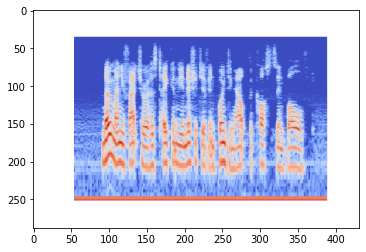

In [11]:
plt.imshow(data)

In [12]:
X, y = load_data(reduction_factor=0.1)

[ 724  384  594 ...  860 1159  829]


In [13]:
split = int(len(X)*0.2)
X_test, X_train = X[:split], X[split:]
y_test, y_train = y[:split], y[split:]

In [14]:
def load_model():
    #model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    model = EfficientNetB0(include_top=False, input_shape=X_train[0].shape)
    return model

In [15]:
model = load_model()
model.summary()

Metal device set to: Apple M1


2021-08-21 15:23:45.546204: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-21 15:23:45.547471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-21 15:23:45.547955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 432, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 288, 432, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 288, 432, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 289, 433, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [16]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False
    
    return model

model = set_nontrainable_layers(model)

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 432, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 288, 432, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 288, 432, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 289, 433, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [17]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(7, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    return model

In [18]:
model = add_last_layers(model)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 9, 14, 1280)       4049571   
_________________________________________________________________
flatten (Flatten)            (None, 161280)            0         
_________________________________________________________________
dense (Dense)                (None, 500)               80640500  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3507      
Total params: 84,693,578
Trainable params: 80,644,007
Non-trainable params: 4,049,571
_________________________________________________________________


In [19]:
def build_model():  
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [20]:
model = build_model()

In [21]:
X_train = preprocess_input(X_train) 
X_test = preprocess_input(X_test)

In [22]:
X_train.shape

(973, 288, 432, 3)

In [23]:
y_train.shape

(973, 7)

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=16, 
                    callbacks=[es])

2021-08-21 15:23:53.075500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-08-21 15:23:55.579577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - ETA: 0s - loss: 5.5290 - accuracy: 0.1684

2021-08-21 15:24:34.898668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 53s 966ms/step - loss: 5.5290 - accuracy: 0.1684 - val_loss: 2.6932 - val_accuracy: 0.1846
Epoch 2/50
49/49 [==============================] - 57s 946ms/step - loss: 1.9580 - accuracy: 0.2301 - val_loss: 2.1903 - val_accuracy: 0.1590
Epoch 3/50
49/49 [==============================] - 42s 836ms/step - loss: 1.6881 - accuracy: 0.3676 - val_loss: 2.3931 - val_accuracy: 0.1487
Epoch 4/50
49/49 [==============================] - 40s 786ms/step - loss: 1.5207 - accuracy: 0.4460 - val_loss: 2.3980 - val_accuracy: 0.1538
Epoch 5/50
49/49 [==============================] - 50s 1s/step - loss: 1.3861 - accuracy: 0.4961 - val_loss: 2.1868 - val_accuracy: 0.1949
Epoch 6/50
49/49 [==============================] - 52s 1s/step - loss: 1.2077 - accuracy: 0.6067 - val_loss: 2.3038 - val_accuracy: 0.1897
Epoch 7/50
49/49 [==============================] - 52s 1s/step - loss: 1.0454 - accuracy: 0.6697 - val_loss: 2.2904 - val_accuracy: 0.1846
Epoch 8/50
49/49 [=